## Imports

In [48]:
import io
import json
import requests
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import datasets, models, transforms

import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder, normalize
from torchmetrics.functional import accuracy

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from torch.autograd import Variable

from tqdm import tqdm
from time import sleep

from pytorch_lightning.callbacks import TQDMProgressBar



In [2]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
device

device(type='cuda', index=0)

## Готовый df

In [3]:
N_EPOCHS = 500
BATCH_SIZE = 500
seq_length = 250


In [4]:
df = pd.read_csv('train_2022_Jun.csv')
df

,timestamp,Open,High,Low,Close,Volume,Count,Target
0,1655337600,22583.72,22622.47,22555.33,22568.17,104.35613,1934,1.0
1,1655337660,22568.17,22606.09,22553.43,22570.41,105.16669,1831,1.0
2,1655337720,22570.42,22653.85,22570.00,22631.85,133.63109,2018,1.0
3,1655337780,22633.99,22714.34,22631.84,22667.71,142.14442,2500,1.0
4,1655337840,22667.70,22746.25,22660.96,22740.04,118.55492,1818,1.0
...,...,...,...,...,...,...,...,...
285126,1672445160,16599.34,16600.32,16594.37,16594.44,68.09939,2465,0.0
285127,1672445220,16594.44,16600.91,16593.56,16599.84,88.83927,2709,0.0
285128,1672445280,16599.84,16601.74,16594.96,16599.30,83.76568,2463,0.0
285129,1672445340,16599.30,16600.21,16593.64,16595.43,44.73432,1797,0.0


In [5]:
df['Target'].value_counts()

0.0    145694
1.0    139437
Name: Target, dtype: int64

In [6]:
df.columns

Index(['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Count',
       'Target'],
      dtype='object')

In [7]:
""" from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance
import pandas as pd

# Commodity Channel Index 
def CCI(data, ndays): 
    TP = (data['High'] + data['Low'] + data['Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(ndays).mean()) / (0.015 * TP.rolling(ndays).std()), name = 'CCI') 
    data = data.join(CCI) 
    return data

# Retrieve the Nifty data from Yahoo finance:

data = pd.DataFrame(df)

# Compute the Commodity Channel Index(CCI) for NIFTY based on the 20-day Moving average
n = 60*3
NIFTY_CCI = CCI(data, n)
CCI = NIFTY_CCI['CCI']

# Plotting the Price Series chart and the Commodity Channel index below
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(data['Close'],lw=1)
plt.title('NSE Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(CCI,'k',lw=0.75,linestyle='-',label='CCI')
plt.legend(loc=2,prop={'size':9.5}) """

" from pandas_datareader import data as pdr\nimport matplotlib.pyplot as plt\nimport yfinance\nimport pandas as pd\n\n# Commodity Channel Index \ndef CCI(data, ndays): \n    TP = (data['High'] + data['Low'] + data['Close']) / 3 \n    CCI = pd.Series((TP - TP.rolling(ndays).mean()) / (0.015 * TP.rolling(ndays).std()), name = 'CCI') \n    data = data.join(CCI) \n    return data\n\n# Retrieve the Nifty data from Yahoo finance:\n\ndata = pd.DataFrame(df)\n\n# Compute the Commodity Channel Index(CCI) for NIFTY based on the 20-day Moving average\nn = 60*3\nNIFTY_CCI = CCI(data, n)\nCCI = NIFTY_CCI['CCI']\n\n# Plotting the Price Series chart and the Commodity Channel index below\nfig = plt.figure(figsize=(7,5))\nax = fig.add_subplot(2, 1, 1)\nax.set_xticklabels([])\nplt.plot(data['Close'],lw=1)\nplt.title('NSE Price Chart')\nplt.ylabel('Close Price')\nplt.grid(True)\nbx = fig.add_subplot(2, 1, 2)\nplt.plot(CCI,'k',lw=0.75,linestyle='-',label='CCI')\nplt.legend(loc=2,prop={'size':9.5}) "

In [8]:
# Ease Of Movement (EVM) Code

# Load the necessary packages and modules
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance
import pandas as pd
 
# Commodity Channel Index 
def CCI(data, ndays): 
    TP = (data['High'] + data['Low'] + data['Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(ndays).mean()) / (0.015 * TP.rolling(ndays).std()), name = 'CCI') 
    data = data.join(CCI) 
    return data

# Ease of Movement 
def EVM(data, ndays): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EVM = dm / br 
    EVM_MA = pd.Series(EVM.rolling(ndays).mean(), name = 'EVM') 
    data = data.join(EVM_MA) 
    return data 

# Simple Moving Average 
def SMA(data, ndays): 
    SMA = pd.Series(data['Close'].rolling(ndays).mean(), name = 'SMA') 
    data = data.join(SMA) 
    return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
    EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                    name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

def BBANDS(data, window):
    MA = data.Close.rolling(window).mean()
    SD = data.Close.rolling(window).std()
    data['UpperBB'] = MA + (2 * SD) 
    data['LowerBB'] = MA - (2 * SD)
    return data

# Force Index 
def ForceIndex(data, ndays): 
    FI = pd.Series(data['Close'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    data = data.join(FI) 
    return data 

# Rate of Change (ROC)
def ROC(data,n):
    N = data['Close'].diff(n)
    D = data['Close'].shift(n)
    ROC = pd.Series(N/D,name='Rate of Change')
    data = data.join(ROC)
    return data 

data = pd.DataFrame(df)

n = 20
NIFTY_ROC = ROC(data,n)
ROC = NIFTY_ROC['Rate of Change']
data = NIFTY_ROC

n = 50
NIFTY_BBANDS = BBANDS(data, n)
data = NIFTY_BBANDS


n = 20
AAPL_ForceIndex = ForceIndex(data,n)
ForceIndex = AAPL_ForceIndex['ForceIndex']
data = AAPL_ForceIndex

# Compute the 14-day Ease of Movement for AAPL
n = 14
AAPL_EVM = EVM(data, n)
AAPL_EVM  = AAPL_EVM.dropna()
EVM = AAPL_EVM['EVM']
data = AAPL_EVM


n = 60*3
NIFTY_CCI = CCI(data, n)
NIFTY_CCI = NIFTY_CCI.dropna()
CCI = NIFTY_CCI['CCI']
data = NIFTY_CCI


n = 9
SMA_NIFTY = SMA(data,n)
SMA_NIFTY = SMA_NIFTY.dropna()
SMA = SMA_NIFTY['SMA']
data = SMA_NIFTY

# Compute the 200-day EWMA for NIFTY
ew = 15
EWMA_NIFTY = EWMA(data,ew)
EWMA_NIFTY = EWMA_NIFTY.dropna()
EWMA = EWMA_NIFTY['EWMA_'  + str(ew)]
data = EWMA_NIFTY

C:\Users\ilya\AppData\Local\Temp\ipykernel_2904\3579223359.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(data['Close'][:200], label='NSE Prices')
C:\Users\ilya\AppData\Local\Temp\ipykernel_2904\3579223359.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(SMA[:200],'g', label='9 SMA (green)')
C:\Users\ilya\AppData\Local\Temp\ipykernel_2904\3579223359.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future 

<AxesSubplot:>

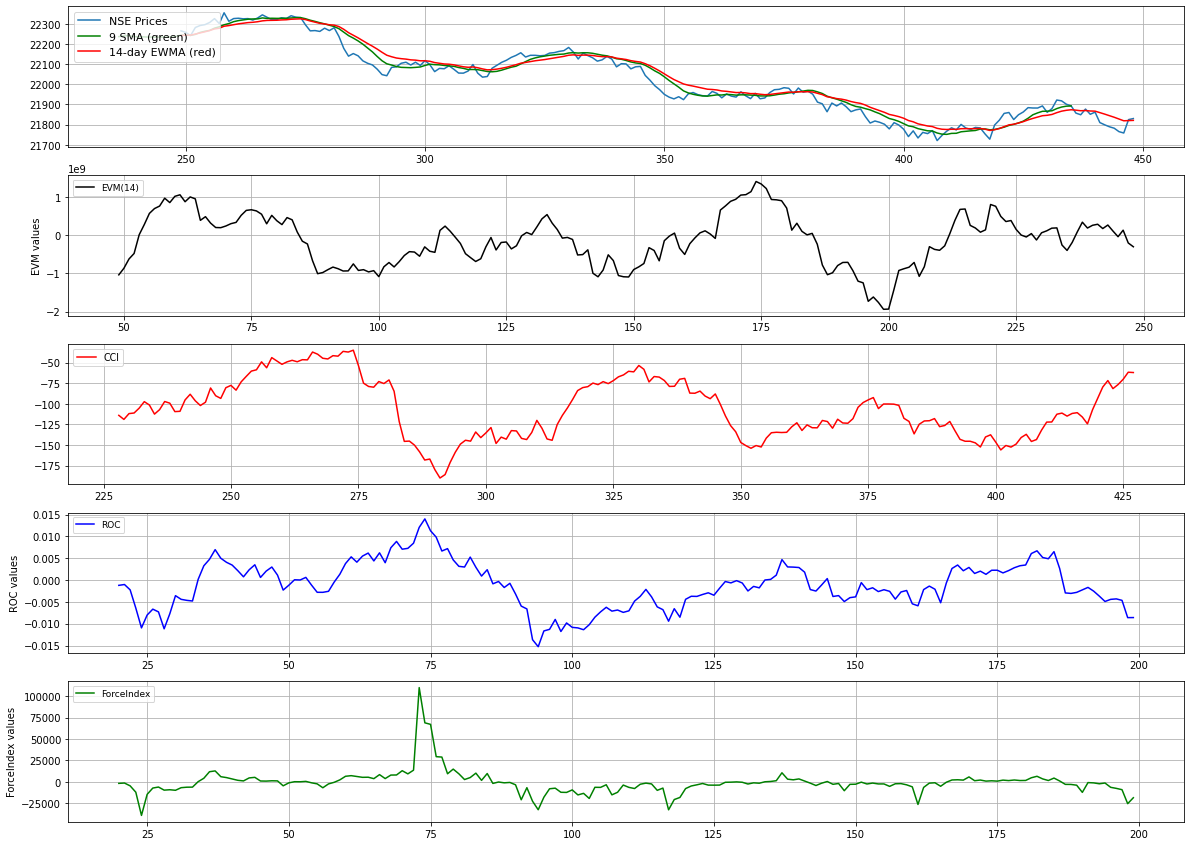

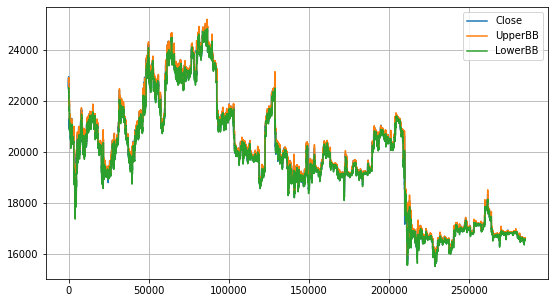

In [9]:
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(5, 1, 1)
plt.plot(data['Close'][:200], label='NSE Prices')
plt.plot(SMA[:200],'g', label='9 SMA (green)')
plt.plot(EWMA[:200],'r', label='14-day EWMA (red)')
plt.legend(loc=2,prop={'size':11})
plt.grid(True)

bx = fig.add_subplot(5, 1, 2)
plt.plot(EVM[:200],'k',linestyle='-',label='EVM(14)')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('EVM values')
plt.grid(True)

сx = fig.add_subplot(5, 1, 3)
plt.plot(CCI[:200],'r',linestyle='-',label='CCI')
plt.legend(loc=2,prop={'size':9.5})
plt.grid(True)

ex = fig.add_subplot(5, 1, 4)
plt.plot(ROC[:200],'b',linestyle='-',label='ROC')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('ROC values')
plt.grid(True)

ex = fig.add_subplot(5, 1, 5)
plt.plot(ForceIndex[:200],'g',linestyle='-',label='ForceIndex')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('ForceIndex values')
plt.grid(True)

pd.concat([NIFTY_BBANDS.Close,NIFTY_BBANDS.UpperBB,NIFTY_BBANDS.LowerBB],axis=1).plot(figsize=(9,5),grid=True)


In [10]:
df = data 
data

,timestamp,Open,High,Low,Close,Volume,Count,Target,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
249,1655352540,22241.69,22272.01,22241.69,22265.94,45.64405,979,1.0,0.001959,22371.600013,22179.761987,1986.885496,1.708244e+07,-80.554032,22244.693333,22242.554903
250,1655352600,22265.94,22280.40,22256.40,22258.00,31.05384,736,1.0,0.000653,22371.609477,22180.109723,450.901757,5.686032e+07,-77.728728,22244.491111,22244.786682
251,1655352660,22258.01,22265.10,22240.99,22242.40,26.36036,569,1.0,0.000476,22371.548674,22179.166926,279.156212,-2.414865e+08,-83.542529,22243.604444,22244.448408
252,1655352720,22242.41,22291.32,22242.40,22282.64,33.19814,853,1.0,0.001264,22370.493590,22179.116810,934.195660,-1.713638e+08,-73.464364,22248.343333,22249.772368
253,1655352780,22282.64,22302.94,22266.34,22292.52,51.71966,864,1.0,0.001359,22370.187252,22179.105548,1564.519715,2.081586e+08,-66.825663,22258.068889,22255.646847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285126,1672445160,16599.34,16600.32,16594.37,16594.44,68.09939,2465,0.0,-0.000852,16617.670956,16587.158644,-963.606369,-2.586268e+06,3.166541,16605.447778,16604.250322
285127,1672445220,16594.44,16600.91,16593.56,16599.84,88.83927,2709,0.0,-0.000547,16617.671827,16587.242573,-807.548964,-2.758590e+06,15.626449,16604.554444,16603.699032
285128,1672445280,16599.84,16601.74,16594.96,16599.30,83.76568,2463,0.0,-0.000388,16617.640824,16587.431576,-540.288636,-1.677894e+06,20.168746,16603.645556,16603.149153
285129,1672445340,16599.30,16600.21,16593.64,16595.43,44.73432,1797,0.0,-0.000551,16617.593324,16587.558276,-409.319028,-3.723131e+06,4.814757,16601.672222,16602.184259


In [11]:
df.head(30)

,timestamp,Open,High,Low,Close,Volume,Count,Target,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
249,1655352540,22241.69,22272.01,22241.69,22265.94,45.64405,979,1.0,0.001959,22371.600013,22179.761987,1986.885496,1.708244e+07,-80.554032,22244.693333,22242.554903
250,1655352600,22265.94,22280.40,22256.40,22258.00,31.05384,736,1.0,0.000653,22371.609477,22180.109723,450.901757,5.686032e+07,-77.728728,22244.491111,22244.786682
251,1655352660,22258.01,22265.10,22240.99,22242.40,26.36036,569,1.0,0.000476,22371.548674,22179.166926,279.156212,-2.414865e+08,-83.542529,22243.604444,22244.448408
252,1655352720,22242.41,22291.32,22242.40,22282.64,33.19814,853,1.0,0.001264,22370.493590,22179.116810,934.195660,-1.713638e+08,-73.464364,22248.343333,22249.772368
253,1655352780,22282.64,22302.94,22266.34,22292.52,51.71966,864,1.0,0.001359,22370.187252,22179.105548,1564.519715,2.081586e+08,-66.825663,22258.068889,22255.646847
254,1655352840,22292.52,22318.30,22291.58,22296.68,32.77570,938,1.0,0.002377,22369.197938,22179.268862,1733.179016,3.394835e+08,-60.420476,22263.951111,22261.216529
255,1655352900,22296.68,22314.70,22295.54,22307.77,22.35770,714,1.0,0.004372,22368.128343,22179.590057,2171.156247,1.106016e+08,-58.831260,22268.266667,22267.468397
256,1655352960,22307.78,22345.36,22307.77,22326.81,44.60896,949,1.0,0.004208,22369.888686,22179.232514,4173.168208,1.486788e+08,-49.199817,22279.383333,22275.364252
257,1655353020,22326.81,22330.49,22300.63,22302.23,35.90714,966,1.0,0.001662,22369.828448,22179.238352,1328.564180,2.113356e+08,-56.374958,22286.110000,22278.910372
258,1655353080,22302.24,22361.98,22290.31,22355.69,47.40024,968,1.0,0.005614,22372.344626,22178.078974,5916.023954,3.700283e+08,-44.044099,22296.082222,22288.974440


### Выделим немного теста

In [12]:
test_len = 0
df_train = df[:len(df)-test_len ]
df_test = df[len(df)-test_len:]

df_train

,timestamp,Open,High,Low,Close,Volume,Count,Target,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
249,1655352540,22241.69,22272.01,22241.69,22265.94,45.64405,979,1.0,0.001959,22371.600013,22179.761987,1986.885496,1.708244e+07,-80.554032,22244.693333,22242.554903
250,1655352600,22265.94,22280.40,22256.40,22258.00,31.05384,736,1.0,0.000653,22371.609477,22180.109723,450.901757,5.686032e+07,-77.728728,22244.491111,22244.786682
251,1655352660,22258.01,22265.10,22240.99,22242.40,26.36036,569,1.0,0.000476,22371.548674,22179.166926,279.156212,-2.414865e+08,-83.542529,22243.604444,22244.448408
252,1655352720,22242.41,22291.32,22242.40,22282.64,33.19814,853,1.0,0.001264,22370.493590,22179.116810,934.195660,-1.713638e+08,-73.464364,22248.343333,22249.772368
253,1655352780,22282.64,22302.94,22266.34,22292.52,51.71966,864,1.0,0.001359,22370.187252,22179.105548,1564.519715,2.081586e+08,-66.825663,22258.068889,22255.646847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285126,1672445160,16599.34,16600.32,16594.37,16594.44,68.09939,2465,0.0,-0.000852,16617.670956,16587.158644,-963.606369,-2.586268e+06,3.166541,16605.447778,16604.250322
285127,1672445220,16594.44,16600.91,16593.56,16599.84,88.83927,2709,0.0,-0.000547,16617.671827,16587.242573,-807.548964,-2.758590e+06,15.626449,16604.554444,16603.699032
285128,1672445280,16599.84,16601.74,16594.96,16599.30,83.76568,2463,0.0,-0.000388,16617.640824,16587.431576,-540.288636,-1.677894e+06,20.168746,16603.645556,16603.149153
285129,1672445340,16599.30,16600.21,16593.64,16595.43,44.73432,1797,0.0,-0.000551,16617.593324,16587.558276,-409.319028,-3.723131e+06,4.814757,16601.672222,16602.184259


In [13]:
df_train = df_train.set_index("timestamp")

#### Смотрим, есть ли разрыввы по дате.

In [14]:
(df_train.index[1:]-df_train.index[:-1]).value_counts()

60    284881
Name: timestamp, dtype: int64

In [15]:
df_train

,Open,High,Low,Close,Volume,Count,Target,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
timestamp,,,,,,,,,,,,,,,
1655352540,22241.69,22272.01,22241.69,22265.94,45.64405,979,1.0,0.001959,22371.600013,22179.761987,1986.885496,1.708244e+07,-80.554032,22244.693333,22242.554903
1655352600,22265.94,22280.40,22256.40,22258.00,31.05384,736,1.0,0.000653,22371.609477,22180.109723,450.901757,5.686032e+07,-77.728728,22244.491111,22244.786682
1655352660,22258.01,22265.10,22240.99,22242.40,26.36036,569,1.0,0.000476,22371.548674,22179.166926,279.156212,-2.414865e+08,-83.542529,22243.604444,22244.448408
1655352720,22242.41,22291.32,22242.40,22282.64,33.19814,853,1.0,0.001264,22370.493590,22179.116810,934.195660,-1.713638e+08,-73.464364,22248.343333,22249.772368
1655352780,22282.64,22302.94,22266.34,22292.52,51.71966,864,1.0,0.001359,22370.187252,22179.105548,1564.519715,2.081586e+08,-66.825663,22258.068889,22255.646847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672445160,16599.34,16600.32,16594.37,16594.44,68.09939,2465,0.0,-0.000852,16617.670956,16587.158644,-963.606369,-2.586268e+06,3.166541,16605.447778,16604.250322
1672445220,16594.44,16600.91,16593.56,16599.84,88.83927,2709,0.0,-0.000547,16617.671827,16587.242573,-807.548964,-2.758590e+06,15.626449,16604.554444,16603.699032
1672445280,16599.84,16601.74,16594.96,16599.30,83.76568,2463,0.0,-0.000388,16617.640824,16587.431576,-540.288636,-1.677894e+06,20.168746,16603.645556,16603.149153


#### Разрывов мало, так что просто reindex с методом pad

In [16]:
df_train = df_train.reindex(range(df_train.index[0],df_train.index[-1]+60,60),method='pad')
(df_train.index[1:]-df_train.index[:-1]).value_counts()

60    284881
Name: timestamp, dtype: int64

In [17]:
df_test = df_test.set_index("timestamp")
(df_test.index[1:]-df_test.index[:-1]).value_counts().head()

Series([], Name: timestamp, dtype: int64)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284882 entries, 1655352540 to 1672445400
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Open            284882 non-null  float64
 1   High            284882 non-null  float64
 2   Low             284882 non-null  float64
 3   Close           284882 non-null  float64
 4   Volume          284882 non-null  float64
 5   Count           284882 non-null  int64  
 6   Target          284882 non-null  float64
 7   Rate of Change  284882 non-null  float64
 8   UpperBB         284882 non-null  float64
 9   LowerBB         284882 non-null  float64
 10  ForceIndex      284882 non-null  float64
 11  EVM             284882 non-null  float64
 12  CCI             284882 non-null  float64
 13  SMA             284882 non-null  float64
 14  EWMA_15         284882 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 32.6 MB


## Dataset

In [19]:
df

,timestamp,Open,High,Low,Close,Volume,Count,Target,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
249,1655352540,22241.69,22272.01,22241.69,22265.94,45.64405,979,1.0,0.001959,22371.600013,22179.761987,1986.885496,1.708244e+07,-80.554032,22244.693333,22242.554903
250,1655352600,22265.94,22280.40,22256.40,22258.00,31.05384,736,1.0,0.000653,22371.609477,22180.109723,450.901757,5.686032e+07,-77.728728,22244.491111,22244.786682
251,1655352660,22258.01,22265.10,22240.99,22242.40,26.36036,569,1.0,0.000476,22371.548674,22179.166926,279.156212,-2.414865e+08,-83.542529,22243.604444,22244.448408
252,1655352720,22242.41,22291.32,22242.40,22282.64,33.19814,853,1.0,0.001264,22370.493590,22179.116810,934.195660,-1.713638e+08,-73.464364,22248.343333,22249.772368
253,1655352780,22282.64,22302.94,22266.34,22292.52,51.71966,864,1.0,0.001359,22370.187252,22179.105548,1564.519715,2.081586e+08,-66.825663,22258.068889,22255.646847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285126,1672445160,16599.34,16600.32,16594.37,16594.44,68.09939,2465,0.0,-0.000852,16617.670956,16587.158644,-963.606369,-2.586268e+06,3.166541,16605.447778,16604.250322
285127,1672445220,16594.44,16600.91,16593.56,16599.84,88.83927,2709,0.0,-0.000547,16617.671827,16587.242573,-807.548964,-2.758590e+06,15.626449,16604.554444,16603.699032
285128,1672445280,16599.84,16601.74,16594.96,16599.30,83.76568,2463,0.0,-0.000388,16617.640824,16587.431576,-540.288636,-1.677894e+06,20.168746,16603.645556,16603.149153
285129,1672445340,16599.30,16600.21,16593.64,16595.43,44.73432,1797,0.0,-0.000551,16617.593324,16587.558276,-409.319028,-3.723131e+06,4.814757,16601.672222,16602.184259


In [20]:

# feature engineering
#df_train = get_row_feats(df_train)

print(df_train.shape)

df_train = df_train.fillna(df_train.mean())

target = 'Target'
drops = ['timestamp']
features = [f for f in df_train.columns if f not in drops + [target]]

print('{:,} features: {}'.format(len(features), features))

(284882, 15)
14 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'Count', 'Rate of Change', 'UpperBB', 'LowerBB', 'ForceIndex', 'EVM', 'CCI', 'SMA', 'EWMA_15']


In [21]:
X_train = df_train[features]
y_train = df_train[target]

In [22]:
X_train

,Open,High,Low,Close,Volume,Count,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
timestamp,,,,,,,,,,,,,,
1655352540,22241.69,22272.01,22241.69,22265.94,45.64405,979,0.001959,22371.600013,22179.761987,1986.885496,1.708244e+07,-80.554032,22244.693333,22242.554903
1655352600,22265.94,22280.40,22256.40,22258.00,31.05384,736,0.000653,22371.609477,22180.109723,450.901757,5.686032e+07,-77.728728,22244.491111,22244.786682
1655352660,22258.01,22265.10,22240.99,22242.40,26.36036,569,0.000476,22371.548674,22179.166926,279.156212,-2.414865e+08,-83.542529,22243.604444,22244.448408
1655352720,22242.41,22291.32,22242.40,22282.64,33.19814,853,0.001264,22370.493590,22179.116810,934.195660,-1.713638e+08,-73.464364,22248.343333,22249.772368
1655352780,22282.64,22302.94,22266.34,22292.52,51.71966,864,0.001359,22370.187252,22179.105548,1564.519715,2.081586e+08,-66.825663,22258.068889,22255.646847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672445160,16599.34,16600.32,16594.37,16594.44,68.09939,2465,-0.000852,16617.670956,16587.158644,-963.606369,-2.586268e+06,3.166541,16605.447778,16604.250322
1672445220,16594.44,16600.91,16593.56,16599.84,88.83927,2709,-0.000547,16617.671827,16587.242573,-807.548964,-2.758590e+06,15.626449,16604.554444,16603.699032
1672445280,16599.84,16601.74,16594.96,16599.30,83.76568,2463,-0.000388,16617.640824,16587.431576,-540.288636,-1.677894e+06,20.168746,16603.645556,16603.149153


In [49]:
d = preprocessing.normalize(X_train, axis=0)
X_train = pd.DataFrame(d, columns=X_train.columns)

In [50]:
X_train

,Open,High,Low,Close,Volume,Count,Rate of Change,UpperBB,LowerBB,ForceIndex,EVM,CCI,SMA,EWMA_15
0,0.002096,0.002098,0.002098,0.002099,0.000377,0.000418,0.001008,0.002101,0.002098,0.000076,0.000249,-0.001609,0.002097,0.002097
1,0.002099,0.002099,0.002099,0.002098,0.000256,0.000314,0.000336,0.002101,0.002098,0.000017,0.000830,-0.001553,0.002097,0.002097
2,0.002098,0.002098,0.002097,0.002097,0.000218,0.000243,0.000245,0.002101,0.002098,0.000011,-0.003523,-0.001669,0.002097,0.002097
3,0.002097,0.002100,0.002098,0.002100,0.000274,0.000364,0.000651,0.002101,0.002098,0.000036,-0.002500,-0.001468,0.002097,0.002097
4,0.002100,0.002101,0.002100,0.002101,0.000427,0.000369,0.000699,0.002101,0.002098,0.000060,0.003037,-0.001335,0.002098,0.002098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284877,0.001565,0.001564,0.001565,0.001564,0.000562,0.001053,-0.000439,0.001561,0.001569,-0.000037,-0.000038,0.000063,0.001565,0.001565
284878,0.001564,0.001564,0.001565,0.001565,0.000734,0.001157,-0.000282,0.001561,0.001569,-0.000031,-0.000040,0.000312,0.001565,0.001565
284879,0.001565,0.001564,0.001565,0.001565,0.000692,0.001052,-0.000200,0.001561,0.001569,-0.000021,-0.000024,0.000403,0.001565,0.001565
284880,0.001565,0.001564,0.001565,0.001564,0.000369,0.000767,-0.000284,0.001561,0.001569,-0.000016,-0.000054,0.000096,0.001565,0.001565


In [23]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train)
print(encoded_labels[:10])
print("Label Classes: ", label_encoder.classes_)

y_train["label"] = encoded_labels
y_train

[1 1 1 1 1 1 1 1 1 1]
Label Classes:  [0. 1.]


C:\Users\ilya\AppData\Local\Temp\ipykernel_2904\2633290842.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train["label"] = encoded_labels


timestamp
1655352540                                                  1.0
1655352600                                                  1.0
1655352660                                                  1.0
1655352720                                                  1.0
1655352780                                                  1.0
                                    ...                        
1672445220                                                  0.0
1672445280                                                  0.0
1672445340                                                  0.0
1672445400                                                  0.0
label         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, ...
Name: Target, Length: 284883, dtype: object

In [24]:
len(X_train)

284882

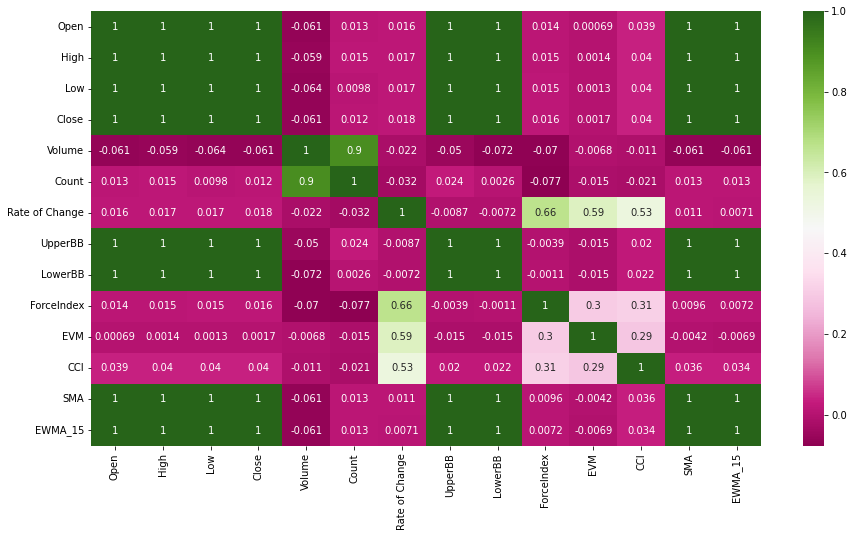

In [51]:
import seaborn as sns
corr = X_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
#with sns.axes_style("darkgrid"):
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, annot = True, cmap = 'PiYG')

In [45]:
sequences =[]

for idx in range(len(X_train) - seq_length):
    x = X_train[idx:idx + seq_length]
    y = y_train[idx:idx + seq_length].iloc[0]
    sequences.append((x, y))


In [26]:
""" train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
print("Number of Training Sequences: ", len(train_sequences))
print("Number of Testing Sequences: ", len(test_sequences)) """

train_sequences = sequences
test_sequences = sequences

In [27]:
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        super().__init__()
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence = torch.Tensor(sequence.values),
            label = torch.tensor(label).long()
        )

In [28]:
class SurfaceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            drop_last = True
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            drop_last = True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            drop_last = True
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            drop_last = True
        )

In [29]:
data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

In [52]:
X_test = df_train[features][1:250]

In [32]:
class Test(pl.LightningDataModule):
    def __init__(self, test_sequences):
        super().__init__()
        self.test_sequences = test_sequences

    def len(self):
        return len(test_sequences)
    
    def setup(self, stage=None):
        self.test_dataset = SurfaceDataset(self.test_sequences)

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            shuffle = False,
            drop_last = True
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            shuffle = False,
            drop_last = True
        )

In [33]:
test = Test(X_test)

In [34]:
class SequenceModel(pl.LightningModule):
  def __init__(self, n_features, n_classes, n_hidden=400, n_layers=2):
    super().__init__()

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers, # Stack LSTMs
        dropout = 0.3
    )

    self.liner1 = nn.Linear(n_hidden, n_classes)
    #self.batchnorm1 = nn.BatchNorm1d(n_hidden)


  def forward(self, x):


    _, (hidden, _) = self.lstm(x)
    # We want the output from the last layer to go into the final
    # regressor linear layer
    out = hidden[-1] 
    #print(f'befor sfotmax: {out}')
    #print(f'after sfotmax: {out}')

    return out

In [35]:
class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
    
    def to_torchscript(self):
        return self.model.to_torchscript()
    
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
 
        if labels is not None:
            output = Variable(torch.randn(BATCH_SIZE, len(label_encoder.classes_)).float(), requires_grad=True).to(device)
            labels = Variable(torch.FloatTensor(BATCH_SIZE).uniform_(0, len(label_encoder.classes_)).long()).to(device)
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):

        sequences = batch["sequence"]
        labels = batch["label"]
 
        
        loss, outputs = self.forward(sequences, labels)

        #print(outputs.shape, labels.shape)
        #print('1')

        predictions = torch.argmax(outputs, dim=1)
        #print('2')
        step_accuracy = accuracy(predictions, labels)
        #print('3')


        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)

        """ plt.figure(figsize=(40,5)) 


        plt.plot(predictions.cpu(),'--r')
        plt.plot(labels.cpu()) 
        plt.show()
 """
        #print({"training_loss": loss, "training_accuracy": step_accuracy})
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self.forward(sequences, labels)

        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)
        #print('outputs = ', outputs.size(), outputs)
        #print('predictions = ', predictions.size(), predictions)
        #print('labels = ',labels)
        

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)

        #print({"val_loss": loss, "val_accuracy": step_accuracy})

        return {"loss": loss, "accuracy": step_accuracy}

    def test_step(self, batch, batch_idx):
        print(batch_idx)
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self.forward(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)
  
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        f = open('final_predict.txt', 'w')
        print(predictions.cpu().numpy())
        f.write(str(predictions.cpu().numpy()))

      

        return {"loss": loss, "accuracy": step_accuracy}

    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=0.001)
 

In [36]:
model = SurfacePredictor(
    n_features=len(features),
    n_classes=len(label_encoder.classes_)
)

In [37]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs 



In [38]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs", name = "surface_predictor")

#early_stopping_callback = EarlyStopping(monitor = "val_loss")

In [39]:
# Trainer
trainer = pl.Trainer(
    enable_progress_bar=True,
    #log_every_n_steps=2,
    check_val_every_n_epoch = 10,
    logger = logger,
    callbacks=[checkpoint_callback],
    enable_checkpointing=True,
    max_epochs = 10,
    accelerator='gpu',
    devices=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(model, data_module)

a:\python\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory A:\Proga\DP\Kaggle\G-Research_Crypto_Competition\project\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.9 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.798     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

a:\python\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
a:\python\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 9, global step 5690: 'val_loss' reached 0.90275 (best 0.90275), saving model to 'A:\\Proga\\DP\\Kaggle\\G-Research_Crypto_Competition\\project\\checkpoints\\best-checkpoint-v80.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [41]:
torch.save(model.state_dict(), 'model_weights_epochs_500.pth')

In [42]:
model1 = SurfacePredictor(
    n_features=len(features),
    n_classes=len(label_encoder.classes_)
)
model1.load_state_dict(torch.load('model_weights_epochs_500.pth'))
model1.eval()

SurfacePredictor(
  (model): SequenceModel(
    (lstm): LSTM(14, 400, num_layers=2, batch_first=True, dropout=0.3)
    (liner1): Linear(in_features=400, out_features=2, bias=True)
  )
  (criterion): CrossEntropyLoss()
)